In [1]:
#------------------------imports------------------------

from astropy.io import fits
from astropy.wcs import WCS
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')
from astropy import units as u
from astropy.cosmology import Planck18
import math

#------------------------image files------------------------

# example images will only be there if you've run the Astroquery notebook before this one!
imagefolder='../AstroqueryDownload/PKS2014-55/'

#specify which image you would like for the background greyscale and contour colours
# and specify relevent parameters
# the threshold is in the units of the image data, and this would usually be something like 3x the measured rms noise
#note: images downloaded via SkyView (like the examples) don't have beam info in header...

#greyscale
greyscale_im=imagefolder+'PKS2014-55_DSS.fits' #fits data file to load and display in greyscale
greyscale_label='DSS'

#purple 
purple_im=None #fits data file to load and display in purple
purple_thresh=None #threshold for lowest contour (typically 3x rms noise level)
purple_label=None  #legend label for these data
purple_beam=False #plot beam size in corner?

#blue
blue_im=imagefolder+'PKS2014-55_WISE_3.4.fits'
blue_thresh=10 #threshold for lowest contour (typically 3x rms noise level)
blue_label=r'WISE 3.4 $\mu$m'
blue_beam=False #plot beam size in corner?


#yellow
yellow_im=imagefolder+'PKS2014-55_SUMSS_843_MHz.fits'
yellow_thresh=0.01 #threshold for lowest contour (typically 3x rms noise level)
yellow_label='SUMSS 888 MHz'
yellow_beam=False #plot beam size in corner?

#red
red_im=imagefolder+'PKS2014-55_GLEAM_170-231_MHz.fits'
red_thresh=0.1 #threshold for lowest contour (typically 3x rms noise level)
red_label='GLEAM 170-231 MHz'
red_beam=False #plot beam size in corner?

# scalebar, use either a redshift or distance (but not both!)
z=0.06063 #redshift
dist=None # specify this in kpc

scalebar_length_kpc=500 #how large the scale bar is in kpc

#------------------------plot settings------------------------

# change plotting parameters to make it look nicer
# changes font to Computer Modern (LaTeX font)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'cmu serif'
# font sizes
SMALL_SIZE = 6
MEDIUM_SIZE = 7
BIGGER_SIZE = 8
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

# get colour maps and set bad values to be transparent
bluecmap=plt.cm.Blues
bluecmap.set_bad('white',0)
redcmap=plt.cm.Reds
redcmap.set_bad('white',0)
yellowcmap=plt.cm.YlOrBr_r
yellowcmap.set_bad('white',0)
purplecmap=plt.cm.Purples
purplecmap.set_bad('white',0)
greyscale=plt.cm.gray_r
greyscale.set_bad('white',0)

#perceptively uniform cmap that will be used for contours
twilightcmap = plt.cm.get_cmap('twilight')

# contour levels
#the step parameter is the factor of 2^step each contour goes up by
# so use step=1 for contours which double each time
contourexps=np.arange(start=0,stop=32,step=0.5)
contourmults=np.power(2,contourexps)

#------------------------functions and calculations------------------------

# simplifies grabbing data from a fits file, but may not work all the time. 
def fitsopen(filepath):
    #open a fits file and return the data and header
    hdu=fits.open(filepath)
    header=hdu[0].header
    data=hdu[0].data
    hdu.close()
    return(data,header)

if z!=None:
    dist = Planck18.comoving_distance(z) #distance in MPc
    scale=Planck18.arcsec_per_kpc_comoving(z) # scale in arcsec per kpc
    sb_length_arcsec=scale*scalebar_length_kpc*u.kpc
elif dist!=None:
    sb_length_arcsec=(180/math.pi)*3600*u.arcsec*scalebar_length_kpc/dist

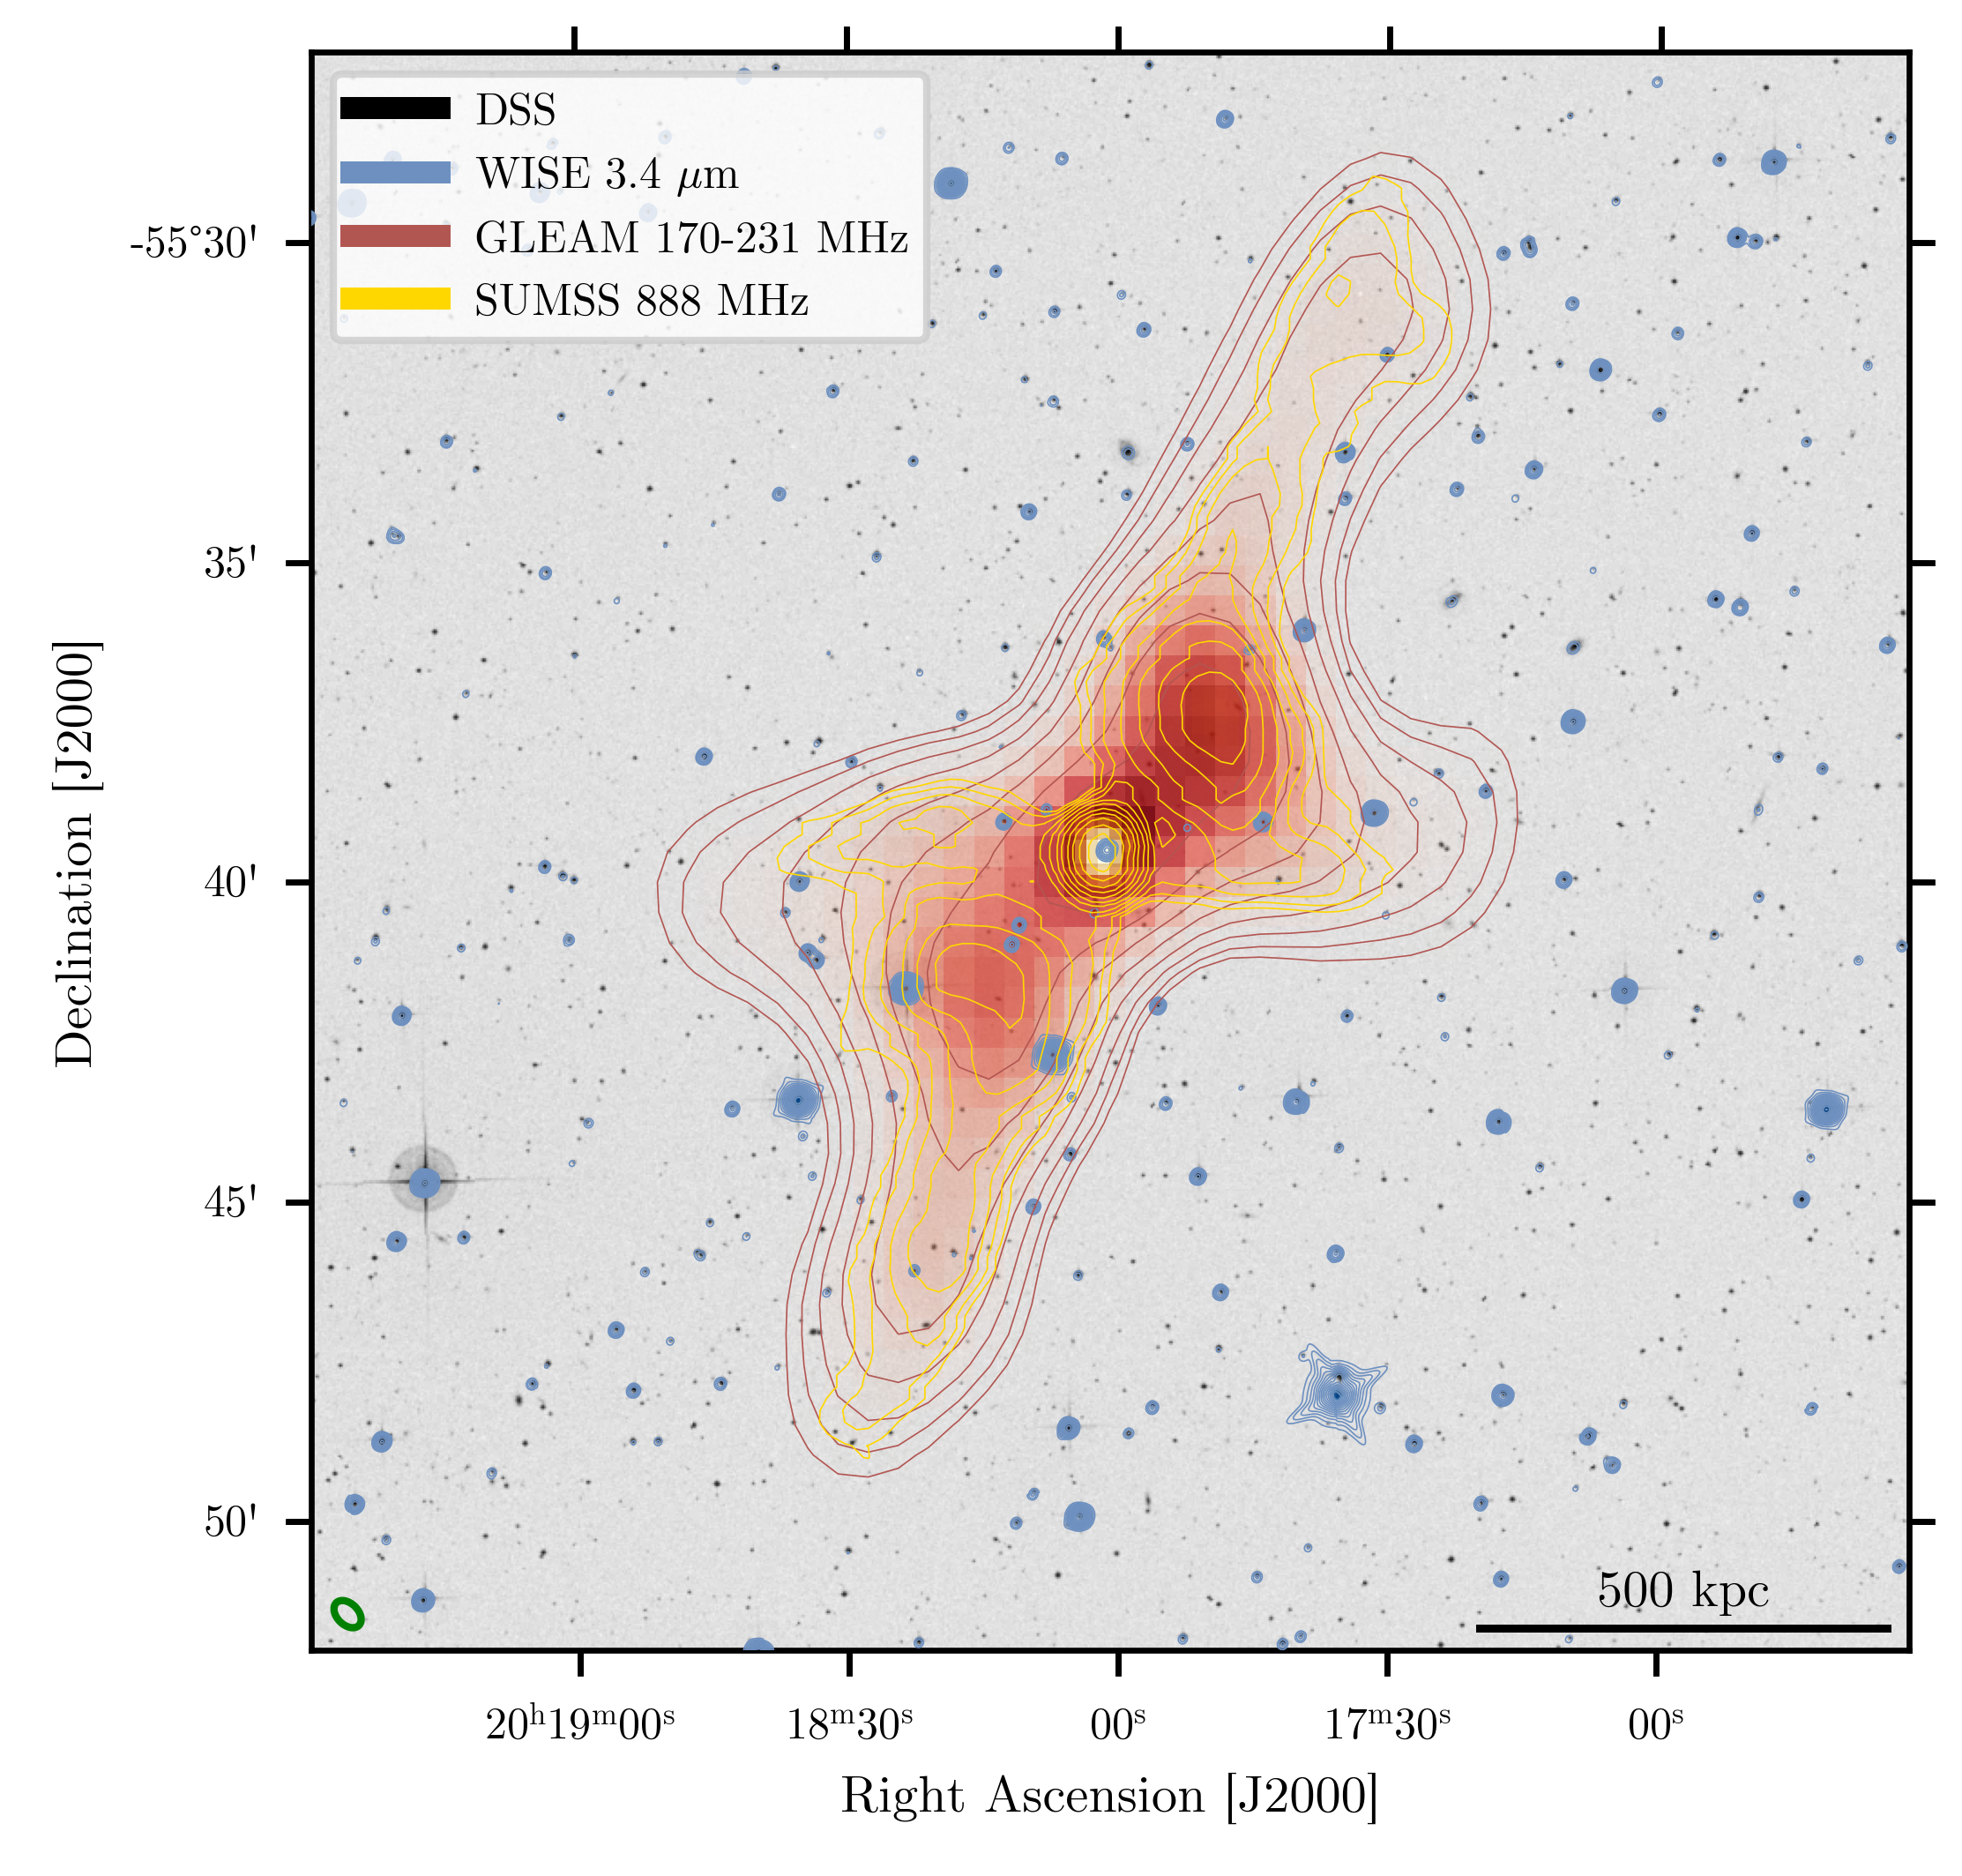

In [7]:
#plot plot plot
plt.figure(dpi=600)

# load the data for the background greyscale 
greyscale_data,greyscale_header=fitsopen(greyscale_im)
wcs=WCS(greyscale_header)
pix_scale=greyscale_header['CDELT2']*3600*u.arcsec
# plot the greyscale
ax=plt.subplot(projection=wcs)
ax.imshow(greyscale_data,origin='lower',cmap=greyscale)

#plot limits, by default use whole plot
xmin=0
xmax=greyscale_data.shape[0]
ymin=0
ymax=greyscale_data.shape[1]

#beam list to plot so can go in order of size
beams=[]

if greyscale_label!=None:
    ax.plot(-100,-100,'-',c='k',label=greyscale_label,linewidth=3)

#purple data
if purple_im!=None:
    purple_data,purple_header=fitsopen(purple_im)
    purple_wcs=WCS(purple_header)
    purple_contours = [purple_thresh * i for i in contourmults]
    ax.contour(purple_data, transform=ax.get_transform(purple_wcs), colors=[twilightcmap(0.4)],levels=purple_contours,linewidths=0.2)

    # calculate transparency array for map (alphas) by normalising the data to be between 0 and 1
    # any data below the threshold value will have alpha=0
    # if you want to saturate the scale at a value lower than the maximum, change np.nanmax(purple_data) in the line below
    purple_alphas=np.divide(purple_data-purple_thresh,np.nanmax(purple_data)-purple_thresh)
    purple_alphas=np.where(purple_alphas<0,0,purple_alphas)
    ax2=plt.imshow(purple_data,origin='lower',transform=ax.get_transform(purple_wcs),cmap=purplecmap,alpha=purple_alphas)    
    if purple_label!=None:
        ax.plot(-100,-100,'-',c=twilightcmap(0.4),label=purple_label,linewidth=3)
    if purple_beam:
        p_bmaj=purple_header['BMAJ']
        p_bmin=purple_header['BMIN']
        p_bpa=purple_header['BPA']
        p_bmaj_pix=p_bmaj/pix_scale
        p_bmin_pix=p_bmin/pix_scale
        beams.append(p_bmaj_pix)
    
#blue data
if blue_im!=None:
    blue_data,blue_header=fitsopen(blue_im)
    blue_wcs=WCS(blue_header)
    blue_contours = [blue_thresh * i for i in contourmults]
    ax.contour(blue_data, transform=ax.get_transform(blue_wcs), colors=[twilightcmap(0.2)],levels=blue_contours,linewidths=0.2)

    # calculate transparency array for map (alphas) by normalising the data to be between 0 and 1
    blue_alphas=np.divide(blue_data-blue_thresh,np.nanmax(blue_data)-blue_thresh)
    blue_alphas=np.where(blue_alphas<0,0,blue_alphas)
    ax3=plt.imshow(blue_data,origin='lower',transform=ax.get_transform(blue_wcs),cmap=bluecmap,alpha=blue_alphas) 
    
    if blue_label!=None:
        ax.plot(-100,-100,'-',c=twilightcmap(0.2),label=blue_label,linewidth=3)
    if blue_beam:
        b_bmaj=blue_header['BMAJ']
        b_bmin=blue_header['BMIN']
        b_bpa=blue_header['BPA']
        b_bmaj_pix=b_bmaj/pix_scale
        b_bmin_pix=b_bmin/pix_scale
        beams.append(b_bmaj_pix)
        
#red data
if red_im!=None: 
    red_data,red_header=fitsopen(red_im)
    red_wcs=WCS(red_header)
    red_contours = [red_thresh * i for i in contourmults]
    ax.contour(red_data, transform=ax.get_transform(red_wcs), colors=[twilightcmap(0.75)],levels=red_contours,linewidths=0.2)
    
    # calculate transparency array for map (alphas) by normalising the data to be between 0 and 1
    red_alphas=np.divide(red_data-red_thresh,np.nanmax(red_data)-red_thresh)
    red_alphas=np.where(red_alphas<0,0,red_alphas)
    ax5=plt.imshow(red_data,origin='lower',transform=ax.get_transform(red_wcs),cmap=redcmap,alpha=red_alphas)
    
    if red_label!=None:
        ax.plot(-100,-100,'-',c=twilightcmap(0.75),label=red_label,linewidth=3)

    if red_beam:
        r_bmaj=red_header['BMAJ']
        r_bmin=red_header['BMIN']
        r_bpa=red_header['BPA']
        r_bmaj_pix=r_bmaj/pix_scale
        r_bmin_pix=r_bmin/pix_scale
        beams.append(r_bmaj_pix)
    
#yellow data
if yellow_im!=None: 
    yellow_data,yellow_header=fitsopen(yellow_im)
    yellow_wcs=WCS(yellow_header)
    yellow_contours = [yellow_thresh * i for i in contourmults]
    ax.contour(yellow_data, transform=ax.get_transform(yellow_wcs), colors=['gold'],levels=yellow_contours,linewidths=0.2)

    # calculate transparency array for map (alphas) by normalising the data to be between 0 and 1
    yellow_alphas=np.divide(yellow_data-yellow_thresh,np.nanmax(yellow_data)-yellow_thresh)
    yellow_alphas=np.where(yellow_alphas<0,0,yellow_alphas)
    ax5=plt.imshow(yellow_data,origin='lower',transform=ax.get_transform(yellow_wcs),cmap=yellowcmap,alpha=yellow_alphas)
    
    if yellow_label!=None:
        ax.plot(-100,-100,'-',c='gold',label=yellow_label,linewidth=3)
        
    if yellow_beam:
        y_bmaj=yellow_header['BMAJ']
        y_bmin=yellow_header['BMIN']
        y_bpa=yellow_header['BPA']
        y_bmaj_pix=y_bmaj/pix_scale
        y_bmin_pix=y_bmin/pix_scale
        beams.append(y_bmaj_pix)
        

#------------------------scale bar and beams------------------------
        
if z!=None or dist!=None: 
    sb_length_pix= sb_length_arcsec/pix_scale
    scalebar=Rectangle(xy=(xmax-sb_length_pix-10,ymin+10),width=sb_length_pix,height=4,edgecolor='none',fc='black',alpha=1)
    ax.add_patch(scalebar)
    scaletext='{} kpc'.format(scalebar_length_kpc)
    plt.annotate(xy=(xmax-(sb_length_pix/2.)-10,ymin+25),text=scaletext,c='black',ha="center")  


#I'm just going to put in an example here as to how you'd put beam info in

bmaj=u.degree*30/3600 #arcsec
bmin=u.degree*20/3600 #arcsec
bpa=45 #degrees
bmaj_pix=bmaj/pix_scale
bmin_pix=bmin/pix_scale

# 20 might need changing depending on image size
ellipse= Ellipse(xy=(xmin+20,ymin+20),width=bmaj_pix,height=bmin_pix,angle=bpa+90,edgecolor='green',fc='None',lw=1)
ax.add_patch(ellipse)

#------------------------final touches------------------------
# finish off the plot
plt.gca().set_aspect("equal")
plt.xlabel('Right Ascension [J2000]')
plt.ylabel('Declination [J2000]')
ax.set_xlim(xmin,ymax)
ax.set_ylim(ymin,ymax)
plt.legend(loc=2)

plt.show()




